In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
import cv2

In [2]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
train_df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
test_df = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')
print(train_df.head(2))
test_df.head(2)

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  

[2 rows x 785 columns]


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0


In [4]:
# labels = data_df['label'].values.tolist()
train_labels = train_df['label'].to_numpy()
test_labels = test_df['label'].to_numpy()
# print(labels)
print(train_labels[:3])
print(train_labels.shape)
print(test_labels[:3])
print(test_labels.shape)

[2 9 6]
(60000,)
[0 1 2]
(10000,)


In [5]:
# img_data = data_df.iloc[:,1:].values.tolist()
train_img_data = train_df.iloc[:,1:].to_numpy()
test_img_data = test_df.iloc[:,1:].to_numpy()
print(train_img_data.shape)
print(test_img_data.shape)

train_img_data = train_img_data.reshape(len(train_img_data),28,28)
test_img_data = test_img_data.reshape(len(test_img_data),28,28)

print(train_img_data.shape)
print(test_img_data.shape)

(60000, 784)
(10000, 784)
(60000, 28, 28)
(10000, 28, 28)


In [6]:
label ="""0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot""".split("\n")
id_2_label ={key:value.split()[-1] for key,value in enumerate(label)} 
label_2_id ={value.split()[-1]:key  for key,value in enumerate(label)}
print(id_2_label)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'boot'}


In [7]:
def display_image(img,title='Image'):
    
    channel = len(img.shape)
    
    if channel <= 2:
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    else:
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

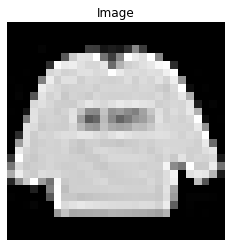

In [8]:
display_image(train_img_data[0])

In [10]:
class CreateModel(nn.Module):
    
    def __init__(self):
        super(CreateModel,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=64,kernel_size=3)
        
        # third hidden layer (Fully connected layer)
        self.fc1 = nn.Linear(in_features=64*(4 * 4),out_features=120)
        # fourth hidden layer (Fully connected layer)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        #output layer
        self.out= nn.Linear(in_features=84,out_features=10)
    
   
    def forward(self, t): #flow of the data/tensor
#         input layer
#         print('input : ',t.size())
        t=t.float()
#         hidden layer 1
        t=self.conv1(t)
#         print('conv1 : ',t.size())
        t=F.relu(t)   #   convolution operation
        t=F.max_pool2d(t,kernel_size =2, stride=2)
#         print('max_poll1 : ',t.size())
#         hidden layer 2
        t=self.conv2(t)
#         print('conv2 : ',t.size())
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2,stride=1)
#         print('max_poll2 : ',t.size())
#         hidden layer 3
        t=self.conv3(t)
#         print('conv3 : ',t.size())
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2,stride=2)
#         print('max_poll2 : ',t.size())
#         flatten
#         t=t.reshape(-1, 64*(4*4))
        t = t.view(-1, self.num_flat_features(t))
#         print('before fc : ',t.size())
#         t=t.view(-1, (64*4*4))
#         hidden layer 4 (fully connected)
        t=self.fc1(t)
#         print('fc1 : ',t.size())
        t=F.relu(t)
#         hidden layer 5 (fully connected)
        t = self.fc2(t)
#         print('fc2 : ',t.size())
        t = F.relu(t)
#         output layer
        t=self.out(t)
#         print(t)
        t=F.log_softmax(t,1)
        return t
    
    def num_flat_features(self, x):
#         print('num_flat : ', x.size())
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
#         print('num_features in : ',num_features)
        return num_features
    
    

In [22]:
x_val, x_test, y_val, y_test = train_test_split(test_img_data, test_labels, test_size=0.5, random_state=42)

print(x_val.shape,' ', x_test.shape)

(5000, 28, 28)   (5000, 28, 28)


In [23]:
x_train = torch.from_numpy(train_img_data)
y_train =torch.from_numpy(train_labels)


# x_test_data = torch.from_numpy(x_test)
# y_test_data= torch.from_numpy(y_test)

x_val = torch.from_numpy(x_val)
y_val= torch.from_numpy(y_val)

In [71]:
def train_model(num_epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data, target
        data = data.reshape(batch_size,-1,28,28)
#         print('data.size :',data.size())
#         data = data.unsqueeze(1)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        loss = compute_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 60 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_dataloader.dataset),
                100. * (batch_idx + 1) / len(train_dataloader), loss.item()))
#         break
            
def evaluate(val_dataloader):
    model.eval()
    loss = 0
    correct = 0
    for data, target in val_dataloader:
#         data = data.unsqueeze(1)
        data, target = data, target
        data=data.reshape(batch_size,-1,28,28)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss +=compute_loss(output, target).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(test_dataloader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(val_dataloader.dataset),
        100. * correct / len(val_dataloader.dataset)))

def predict(model,img=[],desc=False,topk=5,class_name_dict=None):
    correct=0
    size = len(img)
#     print('betch size :',size)
    w,h=img[0].shape
    if size == 1:
        img=torch.from_numpy(img[0])
    else:
        img=torch.from_numpy(img)
    img= img.reshape(size,-1,w,h)

    if torch.cuda.is_available():
        model = model.cuda()
        img= img.cuda()
    output = model(img)
    if desc:
        infer_pred(class_name_dict,output,betch=size)
    pred = output.cpu().data.max(1, keepdim=True)[1]
    pred = pred.numpy()
    if size==1:
        print('Predicted id : ', pred[0])
    return pred

        
def infer_pred(id_2_label,output,topk=5, betch=1):
    pred_prob= nn.functional.softmax(output)
    _,top_K_prob=pred_prob.topk(topk)
    top_K_prob =top_K_prob.cpu().numpy()
    pred_prob=pred_prob.cpu().detach().numpy()
    c=0
    for j in range(betch):
        print('\ntop {} are confidance scores are for Betch ({})  : '.format(topk, j))
        print('No   Pred_id   label      confidance')
        for i in range(topk):
            c=c+1
            print("{},    {},       {},     {} %\
            ".format(c,top_K_prob[j][i],id_2_label[top_K_prob[j][i]],pred_prob[j][i]*100))
#         print(top_K_prob[j])
#         max_id=np.where(top_K_prob[j] == np.amax(top_K_prob[j]))[0][0]
        print('\nPredicted Class: **{}**'.format(id_2_label[np.amax(top_K_prob[j])]))
    
def get_correct_prediction(id_2_label,pred, labels):
    infer_list=[]
    match_list=[]
    incorrect_list=[]
    correct =0
    infer_list.append(['index' ,'Classs Name','Predicted', 'True value', 'Mismatch'])
    for idx,y in enumerate(pred):
        if y==labels[idx]:
            match_list.append(idx)
            correct +=1
            infer_list.append([idx,id_2_label[y[0]],y[0],labels[idx],True])
        else:
            incorrect_list.append((idx, y[0],labels[idx]))
            infer_list.append([idx,id_2_label[y[0]],y[0],labels[idx],False])
    print('Totla : {} , correct prediciton : {} , incorrect : {} \n'.format(len(labels),correct,len(labels)- correct))
    print('Accuracy : {}%'.format(100. * correct / len(labels)))
    return tuple(infer_list), tuple(match_list), tuple(incorrect_list)
    

In [62]:
model = CreateModel()

if torch.cuda.is_available():
    model = model.cuda()
batch_size=1000
# batch_size=1
epochs = 200
compute_loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)


In [63]:

train_dataset=TensorDataset(x_train,y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=batch_size) # create your dataloader

# test_dataset=TensorDataset(x_test,y_test) # create your datset
# test_dataloader =DataLoader(train_dataset,batch_size=batch_size) # create your dataloader

val_dataset=TensorDataset(x_val,y_val) # create your datset
val_dataloader =DataLoader(val_dataset,batch_size=batch_size) # create your dataloader

print(type(train_dataset))
print(type(train_dataloader))

<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [64]:

for i in range(epochs):
    print('starting training..\n')
    train_model(i)
    print('starting evalation \n')
    evaluate(val_dataloader)
    

starting training..

Train Epoch: 0 [60000/60000 (100%)]	Loss: 0.679518
starting evalation 


Average Val Loss: 0.0001, Val Accuracy: 3755/5000 (75.100%)

starting training..

Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.581099
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 3977/5000 (79.540%)

starting training..

Train Epoch: 2 [60000/60000 (100%)]	Loss: 0.507257
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4060/5000 (81.200%)

starting training..

Train Epoch: 3 [60000/60000 (100%)]	Loss: 0.471796
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4126/5000 (82.520%)

starting training..

Train Epoch: 4 [60000/60000 (100%)]	Loss: 0.443883
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4209/5000 (84.180%)

starting training..

Train Epoch: 5 [60000/60000 (100%)]	Loss: 0.403345
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4210/5000 (84.200%)

starting training..

Train Epoch: 6 [60000/60000 (100%)]	Loss: 0.41144

Train Epoch: 53 [60000/60000 (100%)]	Loss: 0.198881
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4490/5000 (89.800%)

starting training..

Train Epoch: 54 [60000/60000 (100%)]	Loss: 0.196511
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4500/5000 (90.000%)

starting training..

Train Epoch: 55 [60000/60000 (100%)]	Loss: 0.195282
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4498/5000 (89.960%)

starting training..

Train Epoch: 56 [60000/60000 (100%)]	Loss: 0.193462
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4501/5000 (90.020%)

starting training..

Train Epoch: 57 [60000/60000 (100%)]	Loss: 0.191458
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4504/5000 (90.080%)

starting training..

Train Epoch: 58 [60000/60000 (100%)]	Loss: 0.189096
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4505/5000 (90.100%)

starting training..

Train Epoch: 59 [60000/60000 (100%)]	Loss: 0.186935
starting eva

Train Epoch: 106 [60000/60000 (100%)]	Loss: 0.123893
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4437/5000 (88.740%)

starting training..

Train Epoch: 107 [60000/60000 (100%)]	Loss: 0.120531
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4428/5000 (88.560%)

starting training..

Train Epoch: 108 [60000/60000 (100%)]	Loss: 0.117450
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4444/5000 (88.880%)

starting training..

Train Epoch: 109 [60000/60000 (100%)]	Loss: 0.115723
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4449/5000 (88.980%)

starting training..

Train Epoch: 110 [60000/60000 (100%)]	Loss: 0.115074
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4434/5000 (88.680%)

starting training..

Train Epoch: 111 [60000/60000 (100%)]	Loss: 0.112581
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4439/5000 (88.780%)

starting training..

Train Epoch: 112 [60000/60000 (100%)]	Loss: 0.110398
start

Train Epoch: 159 [60000/60000 (100%)]	Loss: 0.102947
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4454/5000 (89.080%)

starting training..

Train Epoch: 160 [60000/60000 (100%)]	Loss: 0.097104
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4443/5000 (88.860%)

starting training..

Train Epoch: 161 [60000/60000 (100%)]	Loss: 0.085672
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4439/5000 (88.780%)

starting training..

Train Epoch: 162 [60000/60000 (100%)]	Loss: 0.091310
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4433/5000 (88.660%)

starting training..

Train Epoch: 163 [60000/60000 (100%)]	Loss: 0.092928
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4445/5000 (88.900%)

starting training..

Train Epoch: 164 [60000/60000 (100%)]	Loss: 0.091451
starting evalation 


Average Val Loss: 0.0000, Val Accuracy: 4433/5000 (88.660%)

starting training..

Train Epoch: 165 [60000/60000 (100%)]	Loss: 0.086313
start

In [75]:
idx=1
# pred =predict(model, x_test,desc=True, topk=5,class_name_dict=id_2_label)
pred =predict(model, x_test)
# pred =predict(model, [x_test[0]],desc=True, topk=5,class_name_dict=id_2_label)
# pred =predict(model, [x_test[0]])
# display_image(test_img_data[idx])
# print(test_labels[idx],id_2_label[test_labels[idx]])



Totla : 5000 , correct prediciton : 4510 , incorrect : 490 

Accuracy : 90.2%


In [76]:
details, match, mismatch= get_correct_prediction(id_2_label,pred,y_test)

Totla : 5000 , correct prediciton : 4510 , incorrect : 490 

Accuracy : 90.2%


In [ ]:
def calculate_out_img_size(img, Filter=[None],Stride=[None],Polling=[None]):
    if len(img.shape) > 2:
        w,h,_= img.shape
    else:
        w,h =img.shape
        
    print('W = {}, H = {}'.format(w,h))
        
    for i in range(len(Filter)):
        f = Filter[i]
        p= Polling[i] if Polling[i] else 0
        s = Stride[i] if Stride[i] else 1
        
        w = ((w - f + 2 * p)/s) +1
        h = ((h - f + 2 * p)/s ) +1
        print('layer : ',i+1)
        print('new W = {}, new H = {}'.format(w,h))
            
        

In [ ]:
calculate_out_img_size(train_img_data[0],Filter=[3,2,3,2,3,2],Stride=[0,2,0,0,0,2],Polling=[0,0,0,0,0,0])